# Poisson regression

In [1]:
using CSV
using DataFrames
using Optim
using Random
using StatsBase
using Distributions
import CairoMakie as MK
using GLM
using MixedModels
using StatsFuns

In [34]:
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Optim")
Pkg.add("StatsBase")
Pkg.add("Distributions")
Pkg.add("CairoMakie")
Pkg.add(["GLM", "MixedModels", "Optim", "Distributions"])
Pkg.add("StatsFuns")


   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\DELL\.julia\environments\v1.10\Project.toml`
  No Changes to 

##  Read data

In [2]:
covid = CSV.read("../data/simulated/01-lima-over-dispersion.csv", DataFrame)

Row,districts,population,predictor,cases
,String31,Int64,Float64,Int64
1,San Juan de Lurigancho,1091303,-0.175,136119
2,San Martín de Porres,700178,1.159,120072
3,Ate,630085,-1.042,69214
4,Comas,524894,-0.156,62119
5,Villa El Salvador,463014,1.72,71370
6,Villa María del Triunfo,448545,-1.386,49273
7,San Juan de Miraflores,404001,0.536,64302
8,Los Olivos,371229,-0.786,51088
9,Puente Piedra,353327,0.133,55446


## Point estimate

Only computes the term of loglikelihood that are not constant.

In [15]:
function loglikepoisson(β, data)
    # data
    y = data.cases
    x = data.predictor
    N = data.population

    # loglike function
    η = β[1] .+ x * β[2]
    out = - sum(N .* exp.(η))
    out += sum(y .* η)
end

loglikepoisson (generic function with 1 method)

Minimize the negative loglikelihood.

In [16]:
β0 = [0.0, 0.0]
negloglikepoisson(β) = -loglikepoisson(β, covid)
optim = optimize(negloglikepoisson, β0, Newton(); autodiff = :forward)
β_ml = Optim.minimizer(optim)

2-element Vector{Float64}:
 -2.0011638693781895
  0.12148936630419216

In [17]:
exp.(β_ml)

2-element Vector{Float64}:
 0.1351778622711557
 1.1291773585327725

Compare observed with predicted mean

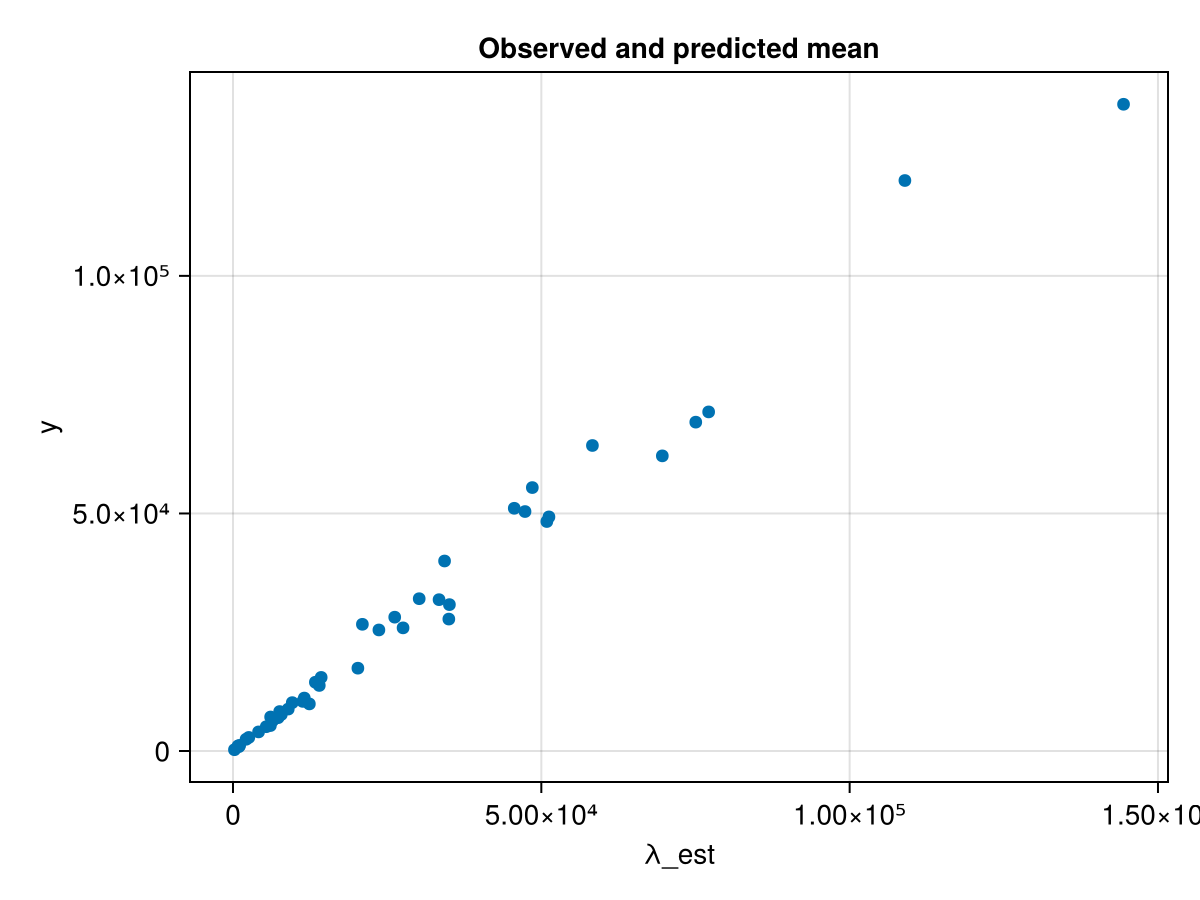

In [18]:
predictpoisreg(β, df) = exp.(β[1] .+ df.predictor * β[2]) .* df.population
λ_est = predictpoisreg(β_ml, covid)
axis_args = (title = "Observed and predicted mean", xlabel = "λ_est", ylabel = "y")
MK.scatter(λ_est, covid.cases, axis = axis_args)

## Bootstrap to obtain confidence interval

Function to obtain regression coefficients.

In [19]:
function poiscoef(data)
    β0 = [0.0, 0.0]
    negloglikepoisson(β) = -loglikepoisson(β, data)
    optim = optimize(negloglikepoisson, β0, Newton(); autodiff = :forward)
    Optim.minimizer(optim)
end

poiscoef (generic function with 1 method)

Bootstrap.

In [20]:
n = size(covid, 1)
m = 5000
bootstraps = zeros(m, 2)
for i = 1:m
    ind_res = sample(1:n, n)
    data_boot = covid[ind_res, :]
    bootstraps[i, :] = poiscoef(data_boot)
end

visualize bootstrap

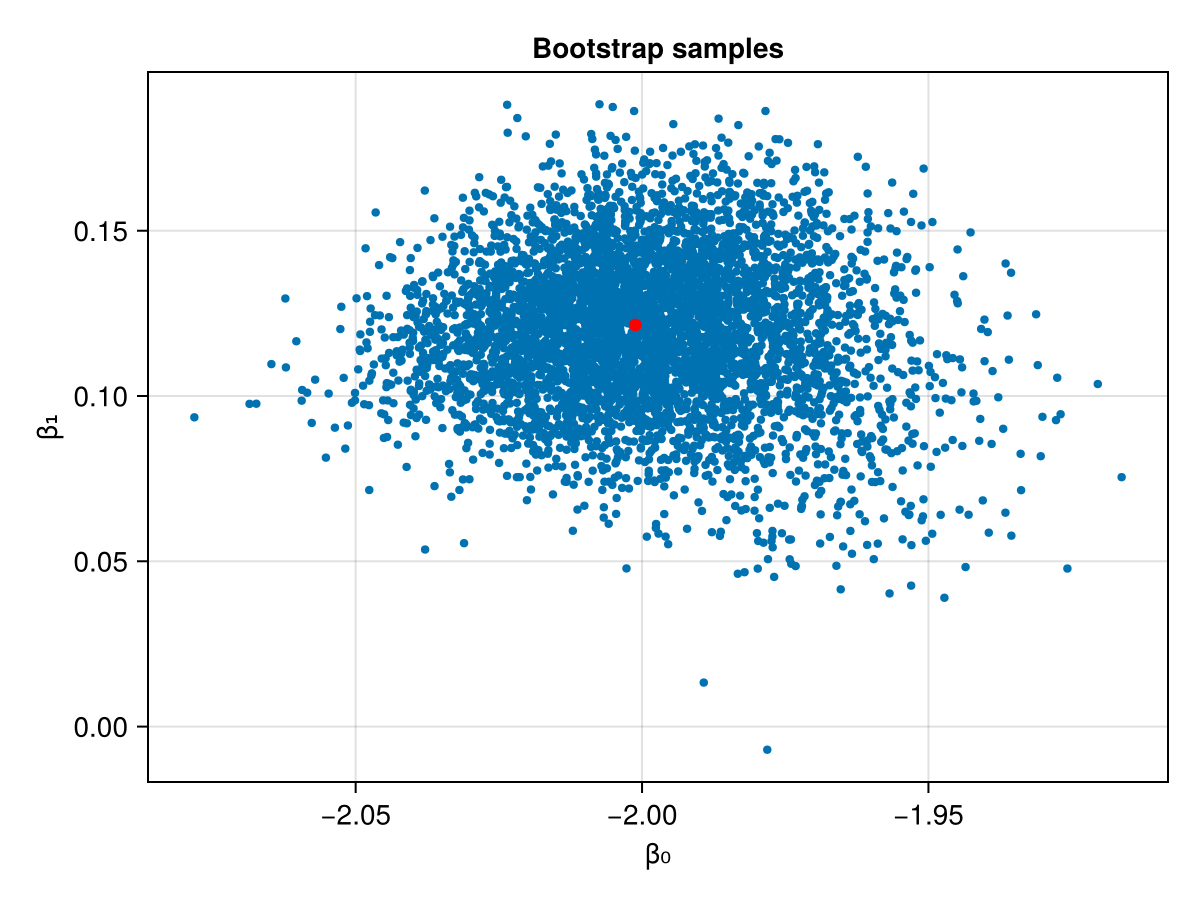

In [21]:
axis_args = (xlabel = "β₀", ylabel = "β₁", title = "Bootstrap samples")
fig = MK.scatter(bootstraps[:,1], bootstraps[:, 2], axis = axis_args, markersize = 6)
MK.scatter!([β_ml[1]], [β_ml[2]], label = "β_est", color = :red)
fig

coeficients and confidente interval

In [23]:
mean(bootstraps[:, 1])

-1.9993067543202734

In [24]:
mean(bootstraps[:, 2])

0.11941142409559317

In [26]:
exp(mean(bootstraps[:, 1]))

0.13542913636491016

In [27]:
exp(mean(bootstraps[:, 2]))

1.126833429356561

In [10]:
α = 0.05
quantile(bootstraps[:, 1], [α/2, 1-α/2])

2-element Vector{Float64}:
 -2.038649198061855
 -1.9583429115930675

In [11]:
quantile(bootstraps[:, 2], [α/2, 1-α/2])

2-element Vector{Float64}:
 0.072508121417135
 0.16498320113752893

## Overdispersion test

Define statistic

In [12]:
over_stat(y, λ) = sum((λ - y) .^ 2 ./ λ)

over_stat (generic function with 1 method)

Computes observed statistic

In [13]:
stat_obs = over_stat(covid.cases, λ_est)

12785.896329483578

Monte carlo sampling to obtain statistic under H₀

In [14]:
m = 1000
mc_stat = zeros(m)
for i = 1:m
    y_mc = rand.(Poisson.(λ_est))
    mc_stat[i] = over_stat(y_mc, λ_est)
end

Distribution and p-value

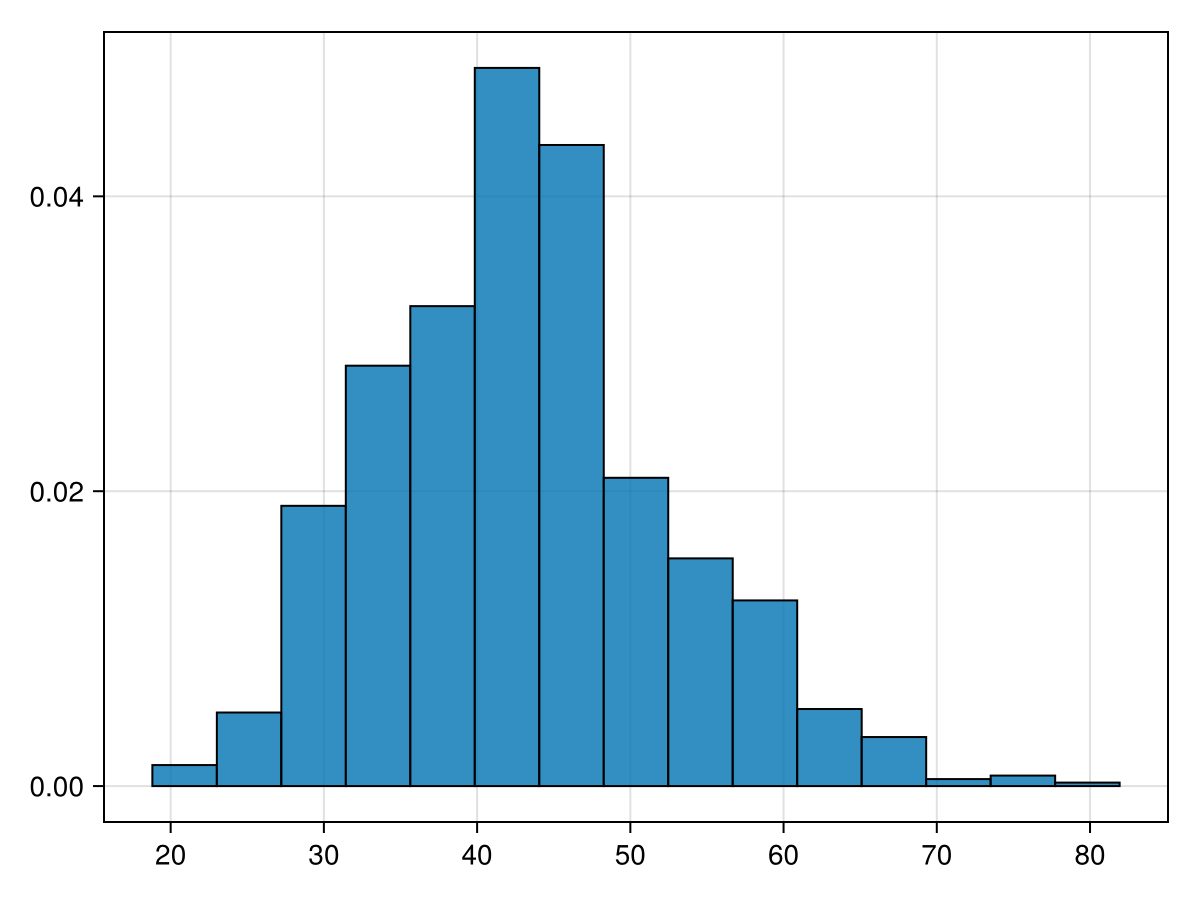

In [15]:
MK.hist(mc_stat, normalization = :pdf, strokewidth = 1)

In [19]:
pvalue = sum(mc_stat .> stat_obs)

0

## Point estimate:  Monte Carlo Expectation-Maximization (MCEM)

In [4]:
using LinearAlgebra, Distributions, Optim

# Función de log-verosimilitud condicional
function loglike_conditional(β, z, y, x, N)
    η = β[1] .+ x .* β[2] .+ z
    λ = N .* exp.(η)
    return sum(logpdf.(Poisson.(λ), y))
end

# Función Q para MCEM
function Q_function(β, σ², data, Z; m = 10)
    y = data.cases
    x = data.predictor
    N = data.population
    q_value = 0.0
    fz = Normal(0.0, sqrt(σ²))
    
    for i in 1:m
        z_i = Z[:, i]
        q_value += loglike_conditional(β, z_i, y, x, N) + sum(logpdf.(fz, z_i))
    end
    
    q_value /= m
    return BigFloat(q_value)
end

# Algoritmo MCEM
function mcem(data, θ0; m = 10, max_iter = 100, tol = 1e-6)
    β = θ0[1:2]
    σ² = exp(θ0[3])
    n = size(data, 1)
    
    for iter in 1:max_iter
        # Paso E: Generar muestras de Z
        qz = Normal(0.0, sqrt(σ²))
        Z = rand(qz, n, m)
        
        # Paso M: Maximizar Q(β, σ²)
        costfunction(β) = -Q_function(β, σ², data, Z; m = m)
        optim = optimize(costfunction, β, BFGS())
        β_new = Optim.minimizer(optim)
        
        # Asegurar que la varianza no se incremente
        η = β_new[1] .+ data.predictor .* β_new[2]
        σ²_new = min(mean((Z .- η).^2), σ²)
        
        println("Iteración: $iter, Parámetros: $β_new, σ²: $σ²_new")
        
        if norm(β_new - β) < tol
            println("Convergencia alcanzada en la iteración $iter")
            break
        end
        
        β = β_new
        σ² = σ²_new
    end
    
    return Dict("β₀" => β[1], "β₁" => β[2], "σ²" => σ²)
end

# Ejemplo de uso
θ0 = [-2.0, 0.1, log(0.41)]
resultados_mcem = mcem(covid, θ0; m = 10000, max_iter = 20)
println("Resultados finales: ", resultados_mcem)

Iteración: 1, Parámetros: [-2.205250919820822, 0.12105714725839666], σ²: 0.41
Iteración: 2, Parámetros: [-2.207835530246802, 0.12152259789995444], σ²: 0.41
Iteración: 3, Parámetros: [-2.203176240113735, 0.12334854100495046], σ²: 0.41
Iteración: 4, Parámetros: [-2.204795502343992, 0.12308477417764324], σ²: 0.41
Iteración: 5, Parámetros: [-2.208031834743631, 0.12318548884917288], σ²: 0.41
Iteración: 6, Parámetros: [-2.205961801190559, 0.12301433638129651], σ²: 0.41
Iteración: 7, Parámetros: [-2.20550658004412, 0.12054243775220415], σ²: 0.41
Iteración: 8, Parámetros: [-2.2097102480426574, 0.12020243013019798], σ²: 0.41
Iteración: 9, Parámetros: [-2.2049538931003716, 0.12236439707313382], σ²: 0.41
Iteración: 10, Parámetros: [-2.2091713567512485, 0.12039214146892212], σ²: 0.41
Iteración: 11, Parámetros: [-2.2057042671296365, 0.12404535912000286], σ²: 0.41
Iteración: 12, Parámetros: [-2.2048028508008297, 0.12133792898716687], σ²: 0.41
Iteración: 13, Parámetros: [-2.204926909618271, 0.1223782

## Point estimate:  Monte Carlo Newton-Raphson (MCNR)

In [9]:
using LinearAlgebra, Distributions, Optim

# Función para calcular la log-verosimilitud condicional
function loglike_conditional(β, z, y, x, N)
    η = β[1] .+ x .* β[2] .+ z
    λ = N .* exp.(η)
    return sum(logpdf.(Poisson.(λ), y))
end

# Gradiente y Hessiano simulados
function gradient_hessian_montecarlo(β, σ², data, Z, m = 10)
    y = data.cases
    x = data.predictor
    N = data.population
    n = length(y)
    
    gradient = zeros(length(β))
    hessian = zeros(length(β), length(β))
    
    for i in 1:m
        z_i = Z[:, i]
        η = β[1] .+ x .* β[2] .+ z_i
        λ = N .* exp.(η)
        W = Diagonal(λ)
        X = hcat(ones(n), x)
        
        grad_i = X' * (y .- λ)
        hess_i = -X' * W * X
        
        gradient += grad_i
        hessian += hess_i
    end
    
    # Promediar sobre m simulaciones
    gradient /= m
    hessian /= m
    
    return gradient, hessian
end

# Algoritmo de Monte Carlo Newton-Raphson (MCNR)
function mcnr(data, θ0; m = 10, max_iter = 100, tol = 1e-6)
    β = θ0[1:2]
    σ² = exp(θ0[3])
    n = size(data, 1)
    
    for iter in 1:max_iter
        # Paso E: Simular Z
        qz = Normal(0.0, sqrt(σ²))
        Z = rand(qz, n, m)
        
        # Calcular gradiente y Hessiano usando Monte Carlo
        gradient, hessian = gradient_hessian_montecarlo(β, σ², data, Z, m)
        
        # Paso M: Actualización de los parámetros con Newton-Raphson
        step = hessian \ gradient
        β += step
        
        # Actualizar σ² basado en los nuevos valores de β
        η = β[1] .+ data.predictor .* β[2]
        σ² = min(mean((Z .- η).^2), σ²)
        
        println("Iteración: $iter, Parámetros: $β, σ²: $σ²")
        
        if norm(step) < tol
            println("Convergencia alcanzada en la iteración $iter")
            break
        end
    end
    
    return Dict("β₀" => β[1], "β₁" => β[2], "σ²" => σ²)
end

# Ejemplo de uso (debes definir el dataframe 'covid' con las variables relevantes)
θ0 = [-2.0, 0.1, log(0.41)]
resultados_mcnr = mcnr(covid, θ0; m = 10000, max_iter = 20)
println("Resultados finales: ", resultados_mcnr)


Iteración: 1, Parámetros: [-1.8145905148038664, 0.08203143999652653], σ²: 0.41
Iteración: 2, Parámetros: [-1.489118461590694, 0.05499253937369828], σ²: 0.41
Iteración: 3, Parámetros: [-0.9768205835787407, 0.022961579265615845], σ²: 0.41
Iteración: 4, Parámetros: [-0.27072675814323144, -0.006405831678876421], σ²: 0.41
Iteración: 5, Parámetros: [0.5841680784119918, -0.02521612964843487], σ²: 0.41
Iteración: 6, Parámetros: [1.5221639900280537, -0.034455413176368445], σ²: 0.41
Iteración: 7, Parámetros: [2.4979005259989244, -0.03827239008886972], σ²: 0.41
Iteración: 8, Parámetros: [3.4887297006576015, -0.039765715689983154], σ²: 0.41
Iteración: 9, Parámetros: [4.485327494519159, -0.04031361795911418], σ²: 0.41
Iteración: 10, Parámetros: [5.484074312602356, -0.04051725201612993], σ²: 0.41
Iteración: 11, Parámetros: [6.483612106032551, -0.04059210043995065], σ²: 0.41
Iteración: 12, Parámetros: [7.483442134546394, -0.040620081208987247], σ²: 0.41
Iteración: 13, Parámetros: [8.48337939985854, -

## Point estimate:  Simulated Maximum Likelihood (SML)

In [3]:
# Función para la log-verosimilitud condicional
function loglike_conditional(β, z, y, x, N)
    η = β[1] .+ x .* β[2] .+ z
    λ = N .* exp.(η)
    sum(logpdf.(Poisson.(λ), y))
end

# Función para la log-verosimilitud con Monte Carlo
function loglike_montecarlo(β, σ², data, Z, qz; m = 10)
    # Get data
    y = data.cases
    x = data.predictor
    N = data.population
    n = length(y)
    
    # Distributions
    fz = Normal(0.0, sqrt(σ²))
    
    # Monte Carlo
    mc_loglike = zeros(m)
    for i in 1:m
        mc_loglike[i] = loglike_conditional(β, Z[:, i], y, x, N)
        mc_loglike[i] += sum(logpdf.(fz, Z[:, i])) - sum(logpdf.(qz, Z[:, i]))
    end
    
    # BigFloat is required for more precision than Float64
    log(mean(exp.(BigFloat.(mc_loglike))))
end

# Parámetros iniciales y configuraciones
m = 10000
θ0 = [-2.0, 0.1, log(0.41)]
qz = Normal(0.0, sqrt(exp(θ0[3])))
Z = rand(qz, size(covid, 1), m)

# Primera optimización
costfunction(θ) = -loglike_montecarlo(θ[1:2], exp(θ[3]), covid, Z, qz; m = m)
optim = optimize(costfunction, θ0, Optim.Options(iterations = 1000))
θ_sml = Optim.minimizer(optim)

# Repetir el algoritmo hasta que el tercer parámetro sea más estable
for i in 1:20
    m = 10000
    θ0 = θ_sml
    qz = Normal(0.0, sqrt(exp(θ0[3])))
    Z = rand(qz, size(covid, 1), m)
    costfunction(θ) = -loglike_montecarlo(θ[1:2], exp(θ[3]), covid, Z, qz; m = m)
    optim = optimize(costfunction, θ0, Optim.Options(iterations = 1000))
    θ_sml = Optim.minimizer(optim)
    println(θ_sml)
end

# Los estimados serían:
Dict("β₀" => θ_sml[1], "β₁" => θ_sml[2], "σ²" => exp(θ_sml[3]))


[-2.193677379750758, 0.23979178786553873, -2.057725354204317]
[-2.068804538906673, 0.13014880394665324, -2.6621739493258767]
[-1.9797807332279895, 0.13259441538318406, -3.2054243979615498]
[-2.0149709643707254, 0.09883611433731217, -3.823547139377447]
[-2.0106166318447483, 0.10980247692708325, -3.8569661662007406]
[-1.9943376974384928, 0.08028444804417326, -4.514081488236499]
[-2.012630178586921, 0.1137261578094141, -4.608551084565047]
[-2.016276781191971, 0.13028108434022936, -4.463689760246602]
[-2.030625527273606, 0.1026148004700598, -4.783053286248169]
[-1.9765235098847826, 0.14097167342662564, -4.708201350428755]
[-1.9919323688454167, 0.12880416395728245, -4.844880311877601]
[-2.0102453360430967, 0.11744059701326315, -4.688984729946254]
[-2.0228050940694002, 0.11775097265183045, -4.97463067997305]
[-2.021783610627287, 0.1349000623052378, -4.794588585865754]
[-1.9580452748084831, 0.12313299772596115, -5.0947971779045815]
[-2.0233532224327044, 0.1155056090414976, -4.934326636741123]

Dict{String, Float64} with 3 entries:
  "β₀" => -1.99053
  "β₁" => 0.126164
  "σ²" => 0.00490751

In [28]:
exp(0.126164)

1.134468205813284

# Zero inflation

In [27]:
dengue = CSV.read("../data/simulated/02-lima-zero-inflation.csv", DataFrame)

Row,districts,population,w,x,cases
,String31,Int64,Float64,Float64,Int64
1,San Juan de Lurigancho,1091303,-1.307,-0.193,53332
2,San Martín de Porres,700178,0.697,1.291,39758
3,Ate,630085,-0.467,-1.589,26701
4,Comas,524894,1.018,-0.219,25613
5,Villa El Salvador,463014,1.897,-0.29,22105
6,Villa María del Triunfo,448545,-0.014,-1.22,19622
7,San Juan de Miraflores,404001,1.306,0.357,0
8,Los Olivos,371229,0.097,-0.932,17180
9,Puente Piedra,353327,-0.001,-1.299,15457


## Point estimate

In [28]:
using Distributions, Optim

# Función para la log-verosimilitud condicional del modelo ZIP
function loglike_zip(β, γ, y, x, w, N)
    # Parámetros para la parte de Poisson y la parte de inflación de ceros
    η = β[1] .+ x .* β[2]
    λ = N .* exp.(η)
    π = 1 ./ (1 .+ exp.(-(γ[1] .+ w .* γ[2])))  # logit(π) = w'γ
    
    # Log-verosimilitud del modelo ZIP
    loglike = 0.0
    for i in 1:length(y)
        if y[i] == 0
            loglike += log((1 - π[i]) + π[i] * exp(-λ[i]))
        else
            loglike += log(π[i]) + logpdf(Poisson(λ[i]), y[i])
        end
    end
    
    return loglike
end


loglike_zip (generic function with 1 method)

In [29]:
# Función de costo para optimización
function cost_function_zip(θ, data)
    β = θ[1:2]  # Parámetros para la parte de Poisson
    γ = θ[3:4]  # Parámetros para la parte de inflación de ceros
    y = data.cases
    x = data.x
    w = data.w
    N = data.population
    
    -loglike_zip(β, γ, y, x, w, N)  # Minimizar la log-verosimilitud negativa
end

# Configuración inicial
θ0 = [-2.0, 0.1, 0.1, -0.1]  # Valores iniciales para [β₀, β₁, γ₀, γ₁]

# Optimización
optim_result = optimize(θ -> cost_function_zip(θ, dengue), θ0, Optim.Options(iterations = 1000))
θ_zip = Optim.minimizer(optim_result)

# Resultados estimados
println("Estimaciones: β₀ = $(θ_zip[1]), β₁ = $(θ_zip[2]), γ₀ = $(θ_zip[3]), γ₁ = $(θ_zip[4])")


Estimaciones: β₀ = -2.999198260019327, β₁ = 0.09988449807551382, γ₀ = 0.8402952877464503, γ₁ = 0.22163709612608018


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*